# **Training - Movie Dataset (Pytorch)**

# Step 1: Setup Environment

## Install packages

In [1]:
# Uninstall existing packages
!pip uninstall azureml-fsspec mltable -y
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y

# Install packages (latest verison)
!pip install -U azureml-fsspec mltable  # azure ml filesystem
!pip install tensorflow==2.11           # tensorflow
!pip install keras==2.11                # keras

Found existing installation: azureml-fsspec 0.1.0b3
Uninstalling azureml-fsspec-0.1.0b3:
  Successfully uninstalled azureml-fsspec-0.1.0b3
Found existing installation: mltable 1.0.0
Uninstalling mltable-1.0.0:
  Successfully uninstalled mltable-1.0.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0
Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
  Using cached azureml_fsspec-0.1.0b3-py3-none-any.whl (6.6 kB)
  Using cached mltable-1.0.0-py3-none-any.whl (149 kB)
  Using cached tensorflow-2.11.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
ERROR: autokeras 1.0.16 has requirement tensorflow<=2.5.0,>=2.3.0, but you'll have tensorflow 2.11.0 which is incompatible.


## Import libraries

In [28]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import ast
from string import punctuation
from gensim.models import KeyedVectors
from mlxtend.plotting import plot_confusion_matrix

# Azure
from azure.storage.blob import BlobServiceClient
from azureml.fsspec import AzureMachineLearningFileSystem

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 

# Sklearn
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix

# Keras
from keras.preprocessing.text import Tokenizer
from keras.models import Model, load_model
from keras.layers import Embedding, LSTM, Dropout, Dense, Input, Bidirectional, Flatten, Conv2D, MaxPooling2D, concatenate, Conv1D, MaxPooling1D
import keras.backend as K
from keras.optimizers import Adam, RMSprop

# Pytorch
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Download packages

In [3]:
# Download natural language toolkit packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Set variables

In [4]:
# Azure Blob Container info
storage_account_url = 'https://umbcmlstorage.blob.core.windows.net/'
storage_account_key = 'Cj2gFlo6CTUhwnQIXEuun0i0NX0Yn1uid3AGrNJ62PKZ6rGXpTUEovv+EcN2jX0sQwxzFvpwGbFZ+AStJJdFuQ=='
blob_service_client_instance = BlobServiceClient(account_url = storage_account_url, credential = storage_account_key)

# AzureML Datastore details
subscription = '9e456110-c6ac-44a7-81cf-5b26a6935c02'
resource_group = 'umbc-machine-learning'
workspace = 'umbc-ml-workspace'
datastore_name = 'azuremldatastore'
datastore_path = f'azureml://subscriptions/{subscription}/resourcegroups/{resource_group}/workspaces/{workspace}/datastores/{datastore_name}'


## Set style

In [5]:
# Style
style.use('seaborn-poster')
style.use('ggplot')

# Step 2: Get saved metadata

## Read from numpy arrays saved

In [13]:
# Read from numpy arrays saved
X_img_val = np.load('val_np_imgs.npy')      # validation images
X_img_test = np.load('test_np_imgs.npy')    # test images
X_img_train = np.load('train_np_imgs.npy')  # train images

## Read train, test, validation data

In [14]:
# Read train, test,validation data
dataset = pd.read_csv(f'{datastore_path}/paths/dataset_mod.csv')    # all dataset
val = pd.read_csv(f'{datastore_path}/paths/val_data.csv')           # validation dataset
test = pd.read_csv(f'{datastore_path}/paths/test_data.csv')         # test dataset
train = pd.read_csv(f'{datastore_path}/paths/train_data.csv')       # train dataset

# Check dataframe
dataset.head()

,Unnamed: 0,original_title,overview,id,genres,genre_list,poster_paths
0,0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","['Animation', 'Comedy', 'Family']",https://umbcmlstorage.blob.core.windows.net/im...
1,1,Jumanji,When siblings Judy and Peter discover an encha...,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","['Adventure', 'Fantasy', 'Family']",https://umbcmlstorage.blob.core.windows.net/im...
2,2,Grumpier Old Men,A family wedding reignites the ancient feud be...,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","['Romance', 'Comedy']",https://umbcmlstorage.blob.core.windows.net/im...
3,3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","['Comedy', 'Drama', 'Romance']",https://umbcmlstorage.blob.core.windows.net/im...
4,4,Father of the Bride Part II,Just when George Banks has recovered from his ...,11862,"[{'id': 35, 'name': 'Comedy'}]",['Comedy'],https://umbcmlstorage.blob.core.windows.net/im...


## Convert genre list column to list

In [15]:
# Converting each cell of the genre list column into a list
dataset['genre_list'] = dataset['genre_list'].apply(lambda x: ast.literal_eval(x))
train['genre_list'] = train['genre_list'].apply(lambda x: ast.literal_eval(x))
test['genre_list'] = test['genre_list'].apply(lambda x: ast.literal_eval(x))
val['genre_list'] = val['genre_list'].apply(lambda x: ast.literal_eval(x))

# Check dataframe
dataset.head()

,Unnamed: 0,original_title,overview,id,genres,genre_list,poster_paths
0,0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[Animation, Comedy, Family]",https://umbcmlstorage.blob.core.windows.net/im...
1,1,Jumanji,When siblings Judy and Peter discover an encha...,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[Adventure, Fantasy, Family]",https://umbcmlstorage.blob.core.windows.net/im...
2,2,Grumpier Old Men,A family wedding reignites the ancient feud be...,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[Romance, Comedy]",https://umbcmlstorage.blob.core.windows.net/im...
3,3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[Comedy, Drama, Romance]",https://umbcmlstorage.blob.core.windows.net/im...
4,4,Father of the Bride Part II,Just when George Banks has recovered from his ...,11862,"[{'id': 35, 'name': 'Comedy'}]",[Comedy],https://umbcmlstorage.blob.core.windows.net/im...


# Step 3: Label generation

## One-hot encoding
Creating one-hot encoded vectors using the Mutltilabel Binarizer from scikit-learn. There are a total of 18 classes and each label is associated with an array index

In [20]:
# Generate one-hot encoded vectors
ml_bin = MultiLabelBinarizer()
ml_bin.fit(dataset['genre_list'].tolist())
ml_bin.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller',
       'War', 'Western'], dtype=object)

## Transformed labels

In [21]:
# Transformed labels
trans_labels = ml_bin.fit_transform(dataset['genre_list'].tolist())  # all labels
print(f'Dataset labels: {trans_labels.shape}')

train_labels = ml_bin.transform(train['genre_list'].tolist())        # train labels
print(f'Train labels: {train_labels.shape}')

test_labels = ml_bin.transform(test['genre_list'].tolist())          # test labels
print(f'Test labels: {test_labels.shape}')

val_labels = ml_bin.transform(val['genre_list'].tolist())            # validation labels
print(f'Validation labels: {val_labels.shape}')

Dataset labels: (39988, 18)
Train labels: (15796, 18)
Test labels: (4393, 18)
Validation labels: (1754, 18)


# Step 4: Text cleaning

## Lemmatization
Cleaning the overview text of the movies, removing punctuation, lowering each word, removal of non-alphabetic words and lemmatization

In [22]:
stop = stopwords.words('english')
wn_lem = WordNetLemmatizer()

def clean_text(text):
  text = text.translate(str.maketrans('', '', punctuation))
  text = text.lower().strip()
  text = ' '.join([i if i not in stop and i.isalpha() else '' for i in text.lower().split()])
  text = ' '.join([wn_lem.lemmatize(w) for w in word_tokenize(text)])
  text = re.sub(r"\s{2,}", " ", text)
  return text

In [23]:
# Lemmatization
train['overview'] = train['overview'].astype(str)
test['overview'] = test['overview'].astype(str)
val['overview'] = val['overview'].astype(str)

train['overview'] = train['overview'].apply(lambda text: clean_text(text))
test['overview'] = test['overview'].apply(lambda text: clean_text(text))
val['overview'] = val['overview'].apply(lambda text: clean_text(text))

dataset['overview'] = dataset['overview'].astype(str)
dataset['overview'] = dataset['overview'].apply(lambda text: clean_text(text))

# Step 5: Text Tokenizing
Fitting the Keras Tokenizer on the entire dataset

In [24]:
# Tokenizing
max_words = 50000
max_seq_len = dataset['overview'].map(len).max()
embedd_dim = 300
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(dataset['overview'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print('Max len:', max_seq_len)

Found 74994 unique tokens.
Max len: 868


# Step 6: Text Embedding

Word2vec is used for text embedding. This function loads the word2vec model and intializes the embedding matrix. 
<br>Each word which is present in the embedding is then added as a vector to the embedding matrix.


## Word2Vec embedding

In [25]:
# Get the GoogleNews-vectors from blob storage
ml_container = 'azureml'
vector_file = 'GoogleNews-vectors-negative300.bin'
vector_instance = blob_service_client_instance.get_blob_client(ml_container, vector_file)

with open(vector_file, 'wb') as my_blob:
    blob_data = vector_instance.download_blob()
    blob_data.readinto(my_blob)

In [26]:
def get_embedding_matrix():
    
  # Load vector file  
  word2vecDict = KeyedVectors.load_word2vec_format(vector_file, binary=True)

  # Embeddings
  embed_size = 300
  embeddings_index = dict()

  # Embedding dictionary
  for word in word2vecDict.wv.vocab:
    embeddings_index[word] = word2vecDict.word_vec(word)

  # Embedding matrix
  print("Loaded " + str(len(embeddings_index)) + " word vectors.")
  embedding_matrix = 1 * np.random.randn(len(word_index)+1, embed_size)

  # Embedding count
  embed_count = 0
  for word, i in word_index.items():
    i -=1
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None: 
      embedding_matrix[i] = embedding_vector
      embed_count+=1

  # Total embedded words
  print("Total embedded:", embed_count, "common words")
  
  # Delete embedding index
  del(embeddings_index)
        
  return embedding_matrix

In [27]:
word2vec_embedding_matrix = get_embedding_matrix()

/tmp/ipykernel_36256/312574656.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  for word in word2vecDict.wv.vocab:


Loaded 3000000 word vectors.
Total embedded: 35332 common words


## Tensor sequences

In [29]:
# Train tensor
X_text_train = tokenizer.texts_to_sequences(train['overview'].values)
X_text_train = pad_sequences(X_text_train, maxlen=max_seq_len)
print('Shape of train tensor:', X_text_train.shape)

# Test tensor
X_text_test = tokenizer.texts_to_sequences(test['overview'].values)
X_text_test = pad_sequences(X_text_test, maxlen=max_seq_len)
print('Shape of test tensor:', X_text_test.shape)

# Validation tensor
X_text_val = tokenizer.texts_to_sequences(val['overview'].values)
X_text_val = pad_sequences(X_text_val, maxlen=max_seq_len)
print('Shape of validation tensor:', X_text_val.shape)

Shape of train tensor: (15796, 868)
Shape of test tensor: (4393, 868)
Shape of validation tensor: (1754, 868)


# Step 7: Implement Model

## Model architecture

The model architecture consists of an LSTM and a CNN. 
<br><br>The LSTM takes the input as a padded sequence of the overview of a movie.
<br>The CNN takes image of movie poster as the input. 

Each model has a fully connected layer whose output is concatenated and fed forward to a final fully connected layer with 18 output units. The output layer has a sigmoid activation function.
<br>Binary crossentropy and Adam optimizer is used as loss function and optimizer respectively

## Configure model

In [30]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Delete model
torch.cuda.empty_cache()

cuda


## Reshape numpy arrays
Reshaping numpy arrays containing image data to (number of images channels width * height).

In [31]:
# Reshape numpy arrays
X_img_val = np.reshape(X_img_val, (X_img_val.shape[0], 3, 75, 115))         # validation array
X_img_test = np.reshape(X_img_test, (X_img_test.shape[0], 3, 75, 115))      # test array
X_img_train = np.reshape(X_img_train, (X_img_train.shape[0], 3, 75, 115))   # train array

## Load text and image inputs
Creating data loaders for the text and image inputs for the train, validation and test sets

In [39]:
# Text and Image tensor dataset
text_train_data = TensorDataset(torch.from_numpy(X_text_train), torch.from_numpy(train_labels))
img_train_data = TensorDataset(torch.from_numpy(X_img_train), torch.from_numpy(train_labels))

text_val_data = TensorDataset(torch.from_numpy(X_text_val), torch.from_numpy(val_labels))
img_val_data = TensorDataset(torch.from_numpy(X_img_val), torch.from_numpy(val_labels))

text_test_data = TensorDataset(torch.from_numpy(X_text_test), torch.from_numpy(test_labels))
img_test_data = TensorDataset(torch.from_numpy(X_img_test), torch.from_numpy(test_labels))

# Text and Image dataloader
batch_size = 64

text_train_loader = DataLoader(text_train_data, batch_size=batch_size)
img_train_loader = DataLoader(img_train_data, batch_size=batch_size)

text_val_loader = DataLoader(text_val_data, batch_size=batch_size)
img_val_loader = DataLoader(img_val_data, batch_size=batch_size)

text_test_loader = DataLoader(text_test_data, batch_size=batch_size)
img_test_loader = DataLoader(img_test_data, batch_size=batch_size)

print(f'Train text: \t{len(text_train_loader)}  \tTrain image:  \t{len(img_train_loader)}')
print(f'Validation text:{len(text_val_loader)}  \tValidation image:{len(img_val_loader)}')
print(f'Test text: \t{len(text_test_loader)}  \tTest image:  \t{len(img_test_loader)}')

Train text: 	247  	Train image:  	247
Validation text:28  	Validation image:28
Test text: 	69  	Test image:  	69


## Compile model
The model consisting of a CNN and LSTM with their outputs being fed into a set of fully connected layers. The final layer consists of 18 output units each having a sigmoid activation

In [40]:
class CNN_LSTM(nn.Module):
  def __init__(self, vocab_size, weights_matrix, n_hidden, n_layers, n_out):
    super(CNN_LSTM, self).__init__()

    # LSTM for the text overview
    self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
    num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
    self.emb = nn.Embedding(num_embeddings, embedding_dim)
    self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
    self.emb.weight.requires_grad = True
    self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
    self.dropout = nn.Dropout(0.1)
    self.lstm_fc = nn.Linear(self.n_hidden, 128)

    # CNN for the posters
    # Creating convolutional layers and subsequently max-pooling
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.max_pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.max_pool2 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.max_pool3 = nn.MaxPool2d(2)
    self.conv4 = nn.Conv2d(128, 128, 3)
    self.max_pool4 = nn.MaxPool2d(2)
    self.cnn_dropout = nn.Dropout(0.1)
    self.cnn_fc = nn.Linear(5*2*128, 512)

    # Concat layer for the combined feature space
    self.combined_fc1 = nn.Linear(640, 256)
    self.combined_fc2 = nn.Linear(256, 128)
    self.output_fc = nn.Linear(128, n_out)

  def forward(self, lstm_inp, cnn_inp):
    batch_size = lstm_inp.size(0)
    hidden = self.init_hidden(batch_size)
    lstm_inp = lstm_inp.long()
    embeds = self.emb(lstm_inp)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = self.dropout(lstm_out[:, -1])
    lstm_out = F.relu(self.lstm_fc(lstm_out))

    # Create fully connected layers on the combined features and max-pooling
    x = F.relu(self.conv1(cnn_inp))
    x = self.max_pool1(x)
    x = F.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = F.relu(self.conv3(x))
    x = self.max_pool3(x)
    x = F.relu(self.conv4(x))
    x = self.max_pool4(x)
    x = x.view(-1, 5*2*128)
    x = self.cnn_dropout(x)
    cnn_out = F.relu(self.cnn_fc(x))

    # Combine outputs from LSTM and CNN
    combined_inp = torch.cat((cnn_out, lstm_out), 1)
    x_comb = F.relu(self.combined_fc1(combined_inp))
    x_comb = F.relu(self.combined_fc2(x_comb))

    # Using the sigmoid activation function
    out = torch.sigmoid(self.output_fc(x_comb))

    return out

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
              weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
    return hidden

## Model Summary

In [41]:
vocab_size = len(word_index)+1
output_size = train_labels.shape[1]
embedding_dim = 300
hidden_dim = 64
n_layers = 2

# Output size
print(f'Output size: {output_size}\n')

# Display model summary
model = CNN_LSTM(vocab_size, word2vec_embedding_matrix, hidden_dim, n_layers, output_size)
model.to(device)
print(model)

Output size: 18

CNN_LSTM(
  (emb): Embedding(74995, 300)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.1, inplace=False)
  (cnn_fc): Linear(in_features=1280, out_features=512, bias=True)
  (combined_fc1): Linear(in_features=640, out_

## Define hyperparameters
Defining the hyperparameters of the model along with defining the optimizer and loss function. Here, the binary cross entropy loss is used. 
<br>The embedding layer with the word2vec embedding is also trainable in order to fine-tune the model. This was done because a sizable portion of the terms in the word2vec vocabulary were missing.

In [42]:
# Used binary cross entropy loss and Adam optimizer
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# Step 8: Training Model

## Training and validation
Training and validation of the model using LSTM and CNN layers
<br><br>PyTorch accumulates the gradients on consecutive backward runs, so Weights want to explicitly set the gradients to zero for each mini-batch during the training phase before beginning to do backpropragation <br>(i.e., updating the Weights and biases).

In [43]:
epochs = 20
clip = 5

# Train model
model.train()

for i in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
    
  # Backpropagation
  for lstm, cnn in zip(text_train_loader, img_train_loader):
    lstm_inp, lstm_labels = lstm
    cnn_inp, cnn_labels = cnn
    lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
    cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
    model.zero_grad()
    output = model(lstm_inp, cnn_inp)
    loss = criterion(output.squeeze(), lstm_labels.float())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    
    with torch.no_grad():
      acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      total_acc_train += acc
      total_loss_train += loss.item()
  
  # Get accuracy and loss for training datasets
  train_acc = total_acc_train/len(text_train_loader)
  train_loss = total_loss_train/len(text_train_loader)

  # Evaluate model
  model.eval()

  tot_acc_val = 0
  tot_loss_val = 0

  with torch.no_grad():
    for lstm, cnn in zip(text_val_loader, img_val_loader):
      lstm_inp, lstm_labels = lstm
      cnn_inp, cnn_labels = cnn
      lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
      cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
      model.zero_grad()
      output = model(lstm_inp, cnn_inp)
      val_loss = criterion(output.squeeze(), lstm_labels.float())
      acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      tot_acc_val += acc
      tot_loss_val += val_loss.item()
    
    # Save model
    print("Saving model...") 
    torch.save(model.state_dict(), f'{datastore_path}/paths/pytorch_word2vec_lstm_less_dropout.pt')
  
  # Get accuracy and loss for validation datasets
  val_acc = tot_acc_val/len(text_val_loader)
  val_loss = tot_loss_val/len(text_val_loader)
  print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')

  # Train model
  model.train()

  # Empty cache
  torch.cuda.empty_cache()

Saving model...
Epoch 1: train_loss: 0.3227 train_acc: 0.8125 | val_loss: 0.3133 val_acc: 0.8347
Saving model...
Epoch 2: train_loss: 0.2938 train_acc: 0.8287 | val_loss: 0.2849 val_acc: 0.8331
Saving model...
Epoch 3: train_loss: 0.2677 train_acc: 0.8424 | val_loss: 0.2745 val_acc: 0.8464
Saving model...
Epoch 4: train_loss: 0.2540 train_acc: 0.8502 | val_loss: 0.2712 val_acc: 0.8473
Saving model...
Epoch 5: train_loss: 0.2415 train_acc: 0.8567 | val_loss: 0.2732 val_acc: 0.8549
Saving model...
Epoch 6: train_loss: 0.2280 train_acc: 0.8638 | val_loss: 0.2720 val_acc: 0.8592
Saving model...
Epoch 7: train_loss: 0.2168 train_acc: 0.8699 | val_loss: 0.2705 val_acc: 0.8537
Saving model...
Epoch 8: train_loss: 0.2094 train_acc: 0.8743 | val_loss: 0.2669 val_acc: 0.8541
Saving model...
Epoch 9: train_loss: 0.2044 train_acc: 0.8772 | val_loss: 0.2668 val_acc: 0.8645
Saving model...
Epoch 10: train_loss: 0.1968 train_acc: 0.8819 | val_loss: 0.2703 val_acc: 0.8581
Saving model...
Epoch 11: tra

## Saving model

In [45]:
# Save model
torch.save(model.state_dict(), f'{datastore_path}/paths/pytorch_word2vec_less_dropout.pt')

# Step 9: Testing Model

## Check accuracy and loss

In [46]:
# Evaluate model
model.eval()

tot_acc_test = 0
tot_loss_test = 0
outputs = []

# Total accuracy and loss
with torch.no_grad():
  for lstm, cnn in zip(text_test_loader, img_test_loader):
    lstm_inp, lstm_labels = lstm
    cnn_inp, cnn_labels = cnn
    lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
    cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
    out = model(lstm_inp, cnn_inp)
    outputs += list(out.cpu().data.numpy())
    loss = criterion(out.squeeze(), lstm_labels.float())
    acc = torch.abs(out.squeeze() - lstm_labels.float()).view(-1)
    acc = (1. - acc.sum() / acc.size()[0])

    tot_acc_test += acc
    tot_loss_test += loss.item()

# Accuracy and Loss test
acc_test = tot_acc_test/len(text_test_loader)
loss_test = tot_loss_test/len(text_test_loader)

print(f'Accuracy: {acc_test:.4f} Loss: {loss_test:.4f}')

Accuracy: 0.8765 Loss: 0.3626


## Prediction and check scores

In [47]:
# Prediction
np_out = np.array(outputs)
y_pred = np.zeros(np_out.shape)
y_pred[np_out>0.5]=1
y_pred = np.array(y_pred)

# Get precision, recall, f1 and accuracy scores along with hamming loss
print(f'Recall score:  \t{recall_score(test_labels, y_pred, average="samples")}')
print(f'Precision score:{precision_score(test_labels, y_pred, average="samples")}')
print(f'F1 score:  \t{f1_score(test_labels, y_pred, average="samples")}')
print(f'Hamming loss:  \t{hamming_loss(test_labels, y_pred)}')
print(f'Accuracy score: {accuracy_score(test_labels, y_pred)}')

Recall score:  	0.4249222247514986
Precision score:0.5174368313225586
F1 score:  	0.43979093724142665
Hamming loss:  	0.10356122113463338
Accuracy score: 0.21056225813794674


## Confusion matrix

Action
accuracy: 0.8349647165945823 precision: 0.551051051051051 recall: 0.46279949558638084 f1: 0.5030843043180261


<Figure size 1280x880 with 0 Axes>

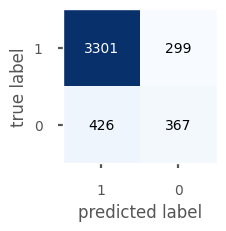

Adventure
accuracy: 0.8695652173913043 precision: 0.3195121951219512 recall: 0.30823529411764705 f1: 0.3137724550898204


<Figure size 1280x880 with 0 Axes>

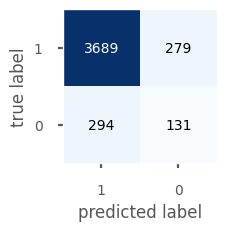

Animation
accuracy: 0.9267015706806283 precision: 0.42971887550200805 recall: 0.37282229965156793 f1: 0.39925373134328357


<Figure size 1280x880 with 0 Axes>

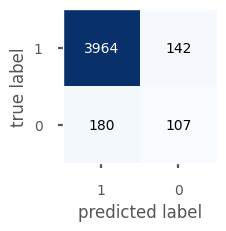

Comedy
accuracy: 0.8026405645344867 precision: 0.5278450363196125 recall: 0.47754654983570644 f1: 0.5014376078205866


<Figure size 1280x880 with 0 Axes>

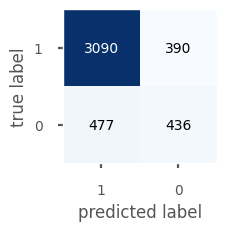

Crime
accuracy: 0.905076257682677 precision: 0.38686131386861317 recall: 0.13730569948186527 f1: 0.20267686424474185


<Figure size 1280x880 with 0 Axes>

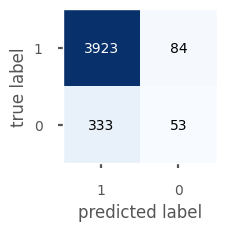

Documentary
accuracy: 0.9073526064193035 precision: 0.688858695652174 recall: 0.7401459854014598 f1: 0.7135819845179451


<Figure size 1280x880 with 0 Axes>

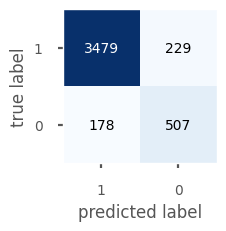

Drama
accuracy: 0.7263828818575006 precision: 0.4891587163920208 recall: 0.4791843670348343 f1: 0.4841201716738197


<Figure size 1280x880 with 0 Axes>

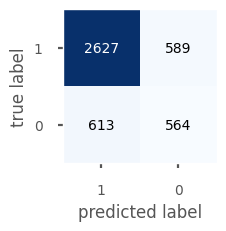

Family
accuracy: 0.9323924425221944 precision: 0.5486725663716814 recall: 0.2012987012987013 f1: 0.2945368171021378


<Figure size 1280x880 with 0 Axes>

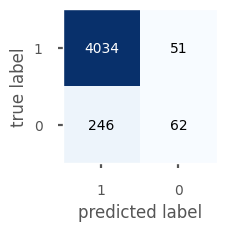

Fantasy
accuracy: 0.933302982016845 precision: 0.2972972972972973 recall: 0.08365019011406843 f1: 0.13056379821958455


<Figure size 1280x880 with 0 Axes>

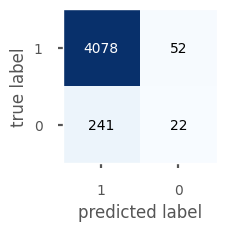

History
accuracy: 0.9740496244024585 precision: 0.08333333333333333 recall: 0.009615384615384616 f1: 0.017241379310344827


<Figure size 1280x880 with 0 Axes>

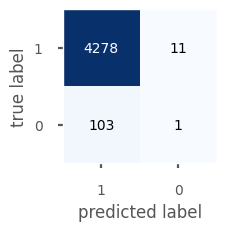

Horror
accuracy: 0.8770771682221716 precision: 0.703601108033241 recall: 0.3697234352256186 f1: 0.48473282442748095


<Figure size 1280x880 with 0 Axes>

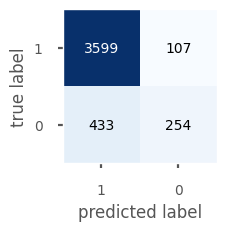

Music
accuracy: 0.9676758479399044 precision: 0.5238095238095238 recall: 0.1527777777777778 f1: 0.23655913978494628


<Figure size 1280x880 with 0 Axes>

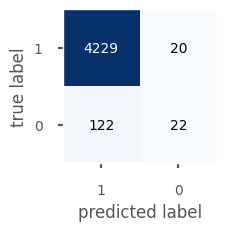

Mystery
accuracy: 0.9353516958798088 precision: 0.25 recall: 0.0035460992907801418 f1: 0.006993006993006993


<Figure size 1280x880 with 0 Axes>

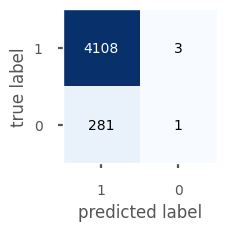

Romance
accuracy: 0.8982472114727976 precision: 0.36923076923076925 recall: 0.18181818181818182 f1: 0.24365482233502533


<Figure size 1280x880 with 0 Axes>

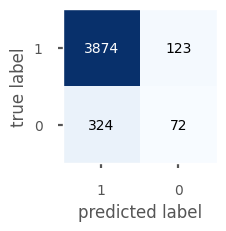

Science Fiction
accuracy: 0.9130434782608695 precision: 0.5914634146341463 recall: 0.43891402714932126 f1: 0.5038961038961038


<Figure size 1280x880 with 0 Axes>

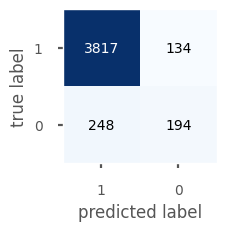

Thriller
accuracy: 0.7974049624402458 precision: 0.5111607142857143 recall: 0.2544444444444444 f1: 0.3397626112759644


<Figure size 1280x880 with 0 Axes>

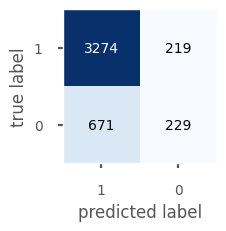

War
accuracy: 0.9692692920555429 precision: 0.18309859154929578 recall: 0.14444444444444443 f1: 0.16149068322981364


<Figure size 1280x880 with 0 Axes>

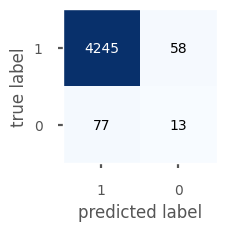

Western
accuracy: 0.9653994992032779 precision: 0.40310077519379844 recall: 0.4094488188976378 f1: 0.40625


<Figure size 1280x880 with 0 Axes>

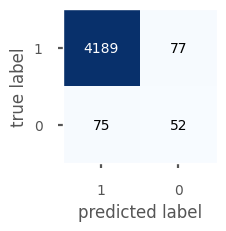

In [48]:
# Get prediction and labels
preds = np.transpose(y_pred)
labels = np.transpose(test_labels)

accuracy_per_class = []
precision_per_class = []
recall_per_class = []
f1_per_class = []
classes = list(ml_bin.classes_)

# Get scores for each genres
for i in range(labels.shape[0]):
  accuracy_per_class.append(accuracy_score(labels[i, :], preds[i, :]))
  precision_per_class.append(precision_score(labels[i, :], preds[i, :]))
  recall_per_class.append(recall_score(labels[i, :], preds[i, :]))
  f1_per_class.append(f1_score(labels[i, :], preds[i, :]))

  print(classes[i])
  print("accuracy:", accuracy_per_class[i], "precision:", precision_per_class[i],
        "recall:", recall_per_class[i], "f1:", f1_per_class[i])

  # Plot confusion matrix
  cm  = confusion_matrix(labels[i, :], preds[i, :])
  plt.figure()
  plot_confusion_matrix(cm,figsize=(2,2), hide_ticks=True, cmap=plt.cm.Blues)
  plt.xticks(range(2), ['1', '0'], fontsize=10)
  plt.yticks(range(2), ['1', '0'], fontsize=10)
  plt.show()

## Accuracy per class

In [49]:
print(f'Accuracy score per class: \t{np.mean(accuracy_per_class)}')
print(f'Precision score per class: \t{np.mean(precision_per_class)}')
print(f'Recall score per class: \t{np.mean(recall_per_class)}')
print(f'F1 score per class: \t\t{np.mean(f1_per_class)}')

Accuracy score per class: 	0.8964387788653667
Precision score per class: 	0.43654299875812397
Recall score per class: 	0.2904289553436568
F1 score per class: 		0.3302004614212573


# Conclusion

We learned a lot about the entire machine learning approach to issue solving throughout the course of the project. The processes in the data preparation process include analyzing the data sources, cleaning and preparing the data, training different neural network models, and finally evaluating the outcomes. 

Our model's multi-genre classification accuracy was around 86%, which appears to be above average. This could be as a result of the few posters that are classified under just one genre. Albeit, we have tried to decrease the class imbalance by under sampling the dataset. We brought down the number of posters for drama from around 20,000 to 6,000 to even out the dataset.

Our findings demonstrate that a neural network may be trained to recognize some of the semantics of a movie poster. But, there is still a lot of work to be done in image processing. Up to the moment where such models can actually be utilized to automatically classify trailers or other media in practice, more research might produce better outcomes. Given that CNN and LSTM models outperform other machine learning techniques in this domain, we advise placing additional emphasis on them.
